<a href="https://colab.research.google.com/github/sadiareem/icece_LCC/blob/main/95_resnet50_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
from pathlib import Path
import PIL

# Mount Google Drive
drive.mount('/content/drive')

# Paths
dataset_path = '/content/drive/MyDrive/Datasets/lungCT'
data_dir = Path(dataset_path)

# Image Data Generators for loading and augmenting data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2  # Using 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # ResNet50's expected input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Load the ResNet50 base model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the first half of the layers
num_layers = len(base_model.layers)
for layer in base_model.layers[:num_layers // 2]:
    layer.trainable = False

# Add custom top layers properly after the base model's output
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


output_layer = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the final model by defining inputs and outputs correctly
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 801 images belonging to 4 classes.
Found 199 images belonging to 4 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,772,228 (94.50 MB)

 Trainable params: 22,545,156 (86.00 MB)

 Non-trainable params: 2,227,072 (8.50 MB)

In [ ]:
# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4194 - loss: 1.6145 - val_accuracy: 0.4925 - val_loss: 1.0967
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 681ms/step - accuracy: 0.6368 - loss: 0.8956 - val_accuracy: 0.5377 - val_loss: 0.9113
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - accuracy: 0.7122 - loss: 0.7699 - val_accuracy: 0.6432 - val_loss: 0.8038
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - accuracy: 0.7594 - loss: 0.6255 - val_accuracy: 0.6884 - val_loss: 0.7426
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 682ms/step - accuracy: 0.8050 - loss: 0.5214 - val_accuracy: 0.7437 - val_loss: 0.5744
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - accuracy: 0.8583 - loss: 0.3814 - val_accuracy: 0.7588 - val_loss: 0.5754
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 614ms/step - accuracy: 0.8692 - loss: 0.3324 - val_accuracy: 0.7839 - val_loss: 0.5444
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 600ms/step - accuracy: 0.8630 - loss: 0.3568 - val_accuracy: 0.7940 -

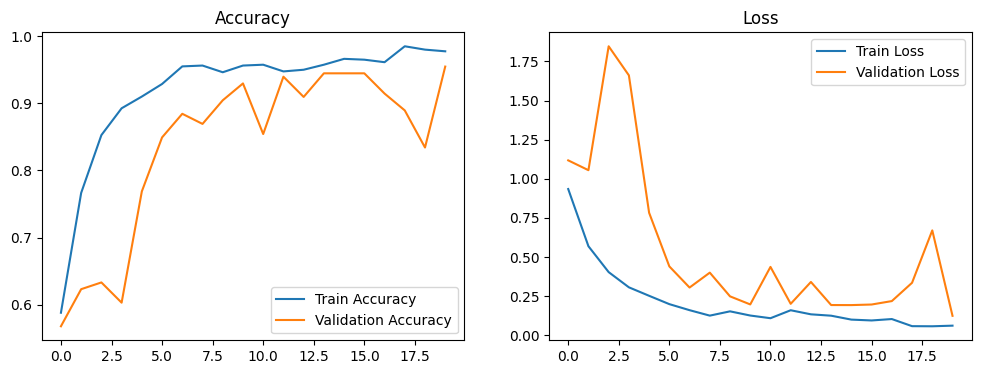

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 857ms/step


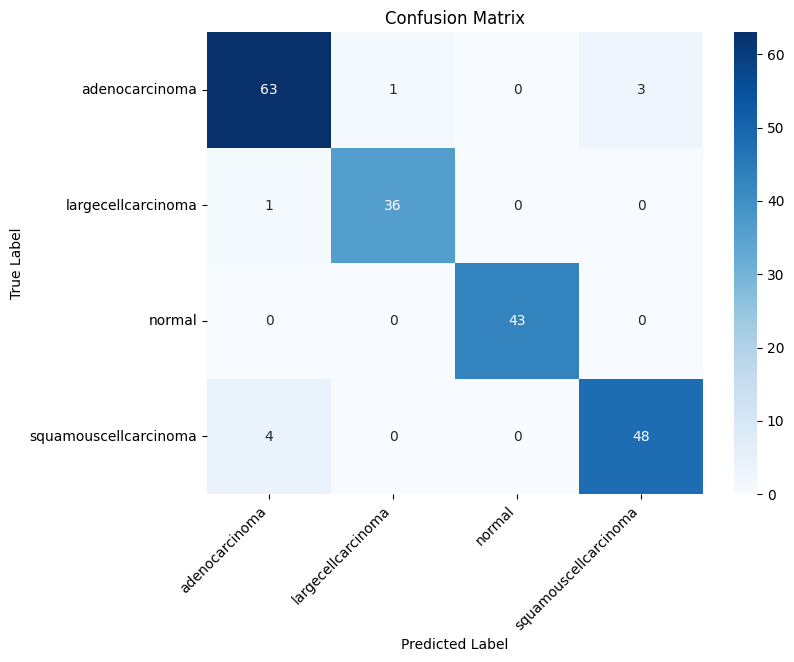

                       precision    recall  f1-score   support

       adenocarcinoma       0.93      0.94      0.93        67
   largecellcarcinoma       0.97      0.97      0.97        37
               normal       1.00      1.00      1.00        43
squamouscellcarcinoma       0.94      0.92      0.93        52

             accuracy                           0.95       199
            macro avg       0.96      0.96      0.96       199
         weighted avg       0.95      0.95      0.95       199



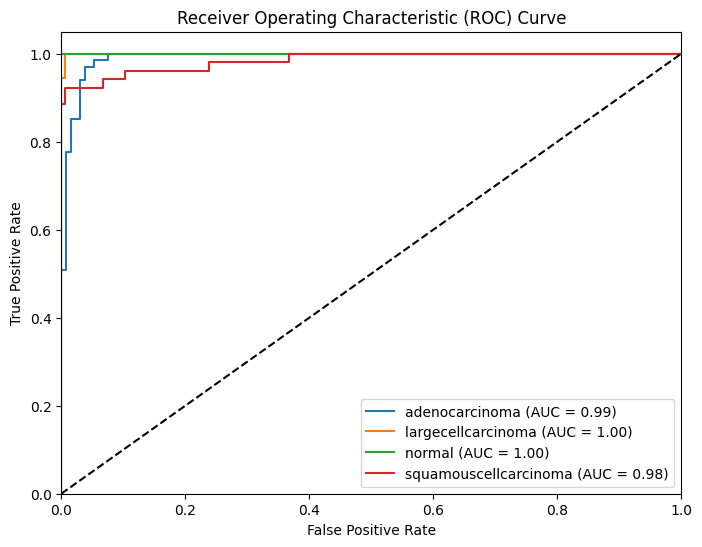

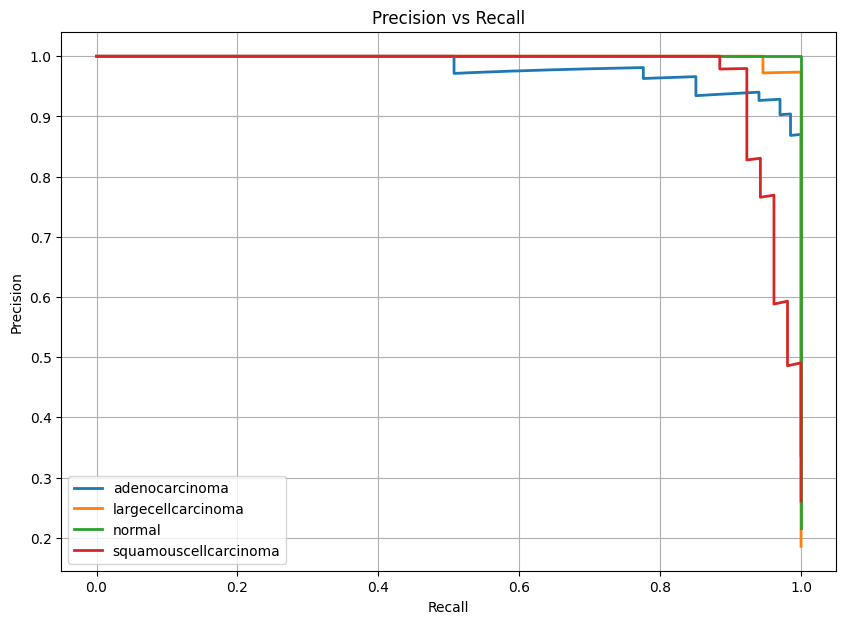

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


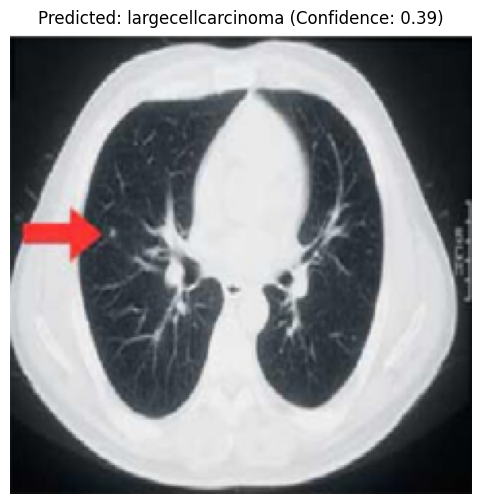

Predicted class: largecellcarcinoma, Confidence: 0.39


In [ ]:
# Plot Accuracy and Loss graphs
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Confusion Matrix and Classification Report
steps = validation_generator.samples // validation_generator.batch_size
y_pred_probs = model.predict(validation_generator, steps=steps + 1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes

# Calculate confusion matrix using class predictions, not probabilities
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = list(validation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Rotate labels on the x-axis
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

# Define class labels
class_labels = ['adenocarcinoma', 'largecellcarcinoma', 'normal', 'squamouscellcarcinoma']

# Compute ROC curve and ROC area for each class
for i in range(4):  # Assuming 4 classes
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])  # Use probabilities, not class labels
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision = {}
recall = {}

# Compute precision-recall curve for each class
for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])  # Use probabilities

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 7))

for i in range(4):
    plt.plot(recall[i], precision[i], lw=2, label=f'{class_labels[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Function to predict new image
def predict_image(image_path):
    try:
        # Load and preprocess the image
        image = PIL.Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
        image = image.resize((224, 224))
        image_array = np.array(image) / 255.0  # Normalize the image

        # Check the number of dimensions and channels of the image
        if image_array.ndim == 3 and image_array.shape[2] == 3:
            image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        else:
            raise ValueError("Image must be RGB with 3 channels")

        # Model prediction
        prediction = model.predict(image_array)

        # Get the predicted class and confidence
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction)

        # Display the image and prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
        plt.show()

        return predicted_class, confidence

    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, None

# Example path to a new image
new_image_path = '/content/drive/My Drive/Datasets/testing/predict.jpg'  # Change to the actual image path
predicted_class, confidence = predict_image(new_image_path)

if predicted_class is not None and confidence is not None:
    print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")
else:
    print("Prediction could not be made.")
